In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from category_encoders import TargetEncoder

<h1> Dicionario de dados </h1>

In [2]:
#lendo o dicionario de dados na pasta arquivos_csv
df_dict = pd.read_csv('arquivos_csv/dicionario_de_dados.csv', sep=';')
df_dict

,Nome,Tipo Dados,Descrição,Contém Dados Sensíveis (LGPD)
0,ano,INT64,Ano de compra / venda do produto,Não
1,sigla_uf,STRING,Sigla da Unidade Federativa da revenda pesquisada,Não
2,id_municipio,STRING,ID Município IBGE - 7 Dígitos,Não
3,bairro_revenda,STRING,Nome do bairro da revenda pesquisada,Não
4,cep_revenda,STRING,Número do Código do Endereço Postal (CEP) do l...,Não
5,endereco_revenda,STRING,Endereço de revenda,Não
6,cnpj_revenda,STRING,Número do Cadastro Nacional de Pessoa Jurídica...,Não
7,nome_estabelecimento,STRING,Nome do estabelecimento,Não
8,bandeira_revenda,STRING,Nome da Bandeira da revenda,Não
9,data_coleta,DATE,Data da coleta do(s) preço(s),Não


In [3]:
#lendo a do arquivo principal de combustiveis
df = pd.read_csv('arquivos_csv/combustiveis.csv')
df.head()

,ano,sigla_uf,cep_revenda,endereco_revenda,cnpj_revenda,nome_estabelecimento,bandeira_revenda,data_coleta,produto,unidade_medida,preco_compra,preco_venda,municipio
0,2021,RJ,26165-225,"AVENIDA JOAQUIM DA COSTA LIMA,5271 LT 6,7,8,9 ...",02.181.025/0001-64,POSTO NOVO AMIGO LTDA,ALESAT,2021-05-24,gasolina aditivada,R$/litro,4.4093,6.299,Belford Roxo
1,2021,SP,14806-150,"AVENIDA MARIA ANTONIA CAMARGO DE OLIVEIRA,3,571",29.017.490/0001-10,JOAQUIM FERREIRA VIEIRA NETO EIRELI,BRANCA,2021-05-24,gasolina aditivada,R$/litro,3.9193,5.599,Araraquara
2,2021,PE,56509-540,"RUA ARMANDO DE SIQUEIRA BRITO,810",32.395.288/0001-37,AUTO POSTO SAO MIGUEL COMERCIO DE COMBUSTIVEIS...,TEMAPE,2021-05-24,gasolina aditivada,R$/litro,3.8493,5.499,Arcoverde
3,2021,SP,13870-260,"RUA TIRADENTES,224",49.386.147/0001-50,COMERCIAL DE PETROLEO REIS LTDA,BRANCA,2021-05-24,gasolina aditivada,R$/litro,3.8843,5.549,São João da Boa Vista
4,2021,BA,43700-000,"RODOVIA BR 324,S/N KM. 605 6 P...",04.136.094/0002-62,G.R.REVENDEDORA DE COMBUSTIVEIS E LUBRIFICANTE...,RAIZEN,2021-05-25,gasolina aditivada,R$/litro,4.3190,6.170,Simões Filho


<h1>1. Preparação dos Dados</h1>

In [4]:
# Nomes das colunas
df.columns

Index(['ano', 'sigla_uf', 'cep_revenda', 'endereco_revenda', 'cnpj_revenda',
       'nome_estabelecimento', 'bandeira_revenda', 'data_coleta', 'produto',
       'unidade_medida', 'preco_compra', 'preco_venda', 'municipio'],
      dtype='object')

In [5]:
# Verificando a existência de possíveis linhas duplicadas
df.duplicated().sum()

0

In [6]:
# Dimensão do Dataset
print('Número de Linhas = ',df.shape[0])
print('Número de Colunas = ',df.shape[1])


Número de Linhas =  26470328
Número de Colunas =  13


In [7]:
# Tipo de Cada Coluna
df.dtypes

ano                       int64
sigla_uf                 object
cep_revenda              object
endereco_revenda         object
cnpj_revenda             object
nome_estabelecimento     object
bandeira_revenda         object
data_coleta              object
produto                  object
unidade_medida           object
preco_compra            float64
preco_venda             float64
municipio                object
dtype: object

In [8]:
unique_values = []
# Verificando os valores únicos por coluna
[(unique_values.append(str(df[coluna].nunique())),print(coluna+' possui '+str(df[coluna].nunique())+' valores únicos')) for coluna in df.columns]

ano possui 18 valores únicos
sigla_uf possui 27 valores únicos
cep_revenda possui 41635 valores únicos
endereco_revenda possui 76924 valores únicos
cnpj_revenda possui 81517 valores únicos
nome_estabelecimento possui 73038 valores únicos
bandeira_revenda possui 268 valores únicos
data_coleta possui 3776 valores únicos
produto possui 7 valores únicos
unidade_medida possui 3 valores únicos
preco_compra possui 108996 valores únicos
preco_venda possui 8048 valores únicos
municipio possui 877 valores únicos


[(None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [9]:
# Excluindo a lista unique_values
del unique_values
gc.collect()

0

In [10]:
# Verificando a existência de possíveis valores ausentes
df.isnull().sum()

ano                     0
sigla_uf                0
cep_revenda             0
endereco_revenda        0
cnpj_revenda            0
nome_estabelecimento    0
bandeira_revenda        0
data_coleta             0
produto                 0
unidade_medida          0
preco_compra            0
preco_venda             0
municipio               0
dtype: int64

<h1>2. Exploração / Visualização dos Dados</h1>

In [11]:
# Estatística Descritiva

# O comando describe retorna parâmetros estatísticos tais como: contagem de linhas, média, desvio 
# padrão, mínimo, máximo, primeiro, segundo e terceiro quartis.
# Deve-se lembrar que este comando só se aplica às variáveis numéricas.

df_describe = df.describe().T
df_describe 

,count,mean,std,min,25%,50%,75%,max
ano,26470328.0,2011.489458,4.871332,2004.0000,2007.00,2011.00,2015.0000,2021.0
preco_compra,26470328.0,8.070097,12.901966,0.3257,1.62,2.10,3.2119,94.5
preco_venda,26470328.0,11.069712,18.069831,0.5900,2.00,2.67,4.1580,135.0


In [12]:
# Definindo as variáveis numéricas e categóricas
num_attributes = df.select_dtypes(include=['int64', 'float64'])
cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

In [13]:
df_skewness  = pd.DataFrame(num_attributes.skew(),columns=['skew'])
df_kurtosis  = pd.DataFrame(num_attributes.kurtosis(),columns=['kurtosis'])
df_median    = pd.DataFrame(num_attributes.median(),columns=['median'])
df_intervalo = pd.DataFrame(num_attributes.max() - num_attributes.min(),columns=['range'])

In [14]:
df_descritive_statistics = pd.concat([df_describe,df_skewness,df_kurtosis,df_median,df_intervalo],axis=1)
df_descritive_statistics

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,median,range
ano,26470328.0,2011.489458,4.871332,2004.0000,2007.00,2011.00,2015.0000,2021.0,0.217931,-1.056744,2011.00,17.0000
preco_compra,26470328.0,8.070097,12.901966,0.3257,1.62,2.10,3.2119,94.5,2.054230,3.577893,2.10,94.1743
preco_venda,26470328.0,11.069712,18.069831,0.5900,2.00,2.67,4.1580,135.0,2.067503,3.651051,2.67,134.4100


In [15]:
# Deletando o dataframe df_descritive_statistics pois não utilizaremos mais futuramente
del df_descritive_statistics, df_skewness, df_kurtosis, df_median, df_intervalo, df_describe
gc.collect()

0

array([[<AxesSubplot: title={'center': 'ano'}>,
        <AxesSubplot: title={'center': 'preco_compra'}>],
       [<AxesSubplot: title={'center': 'preco_venda'}>, <AxesSubplot: >]],
      dtype=object)

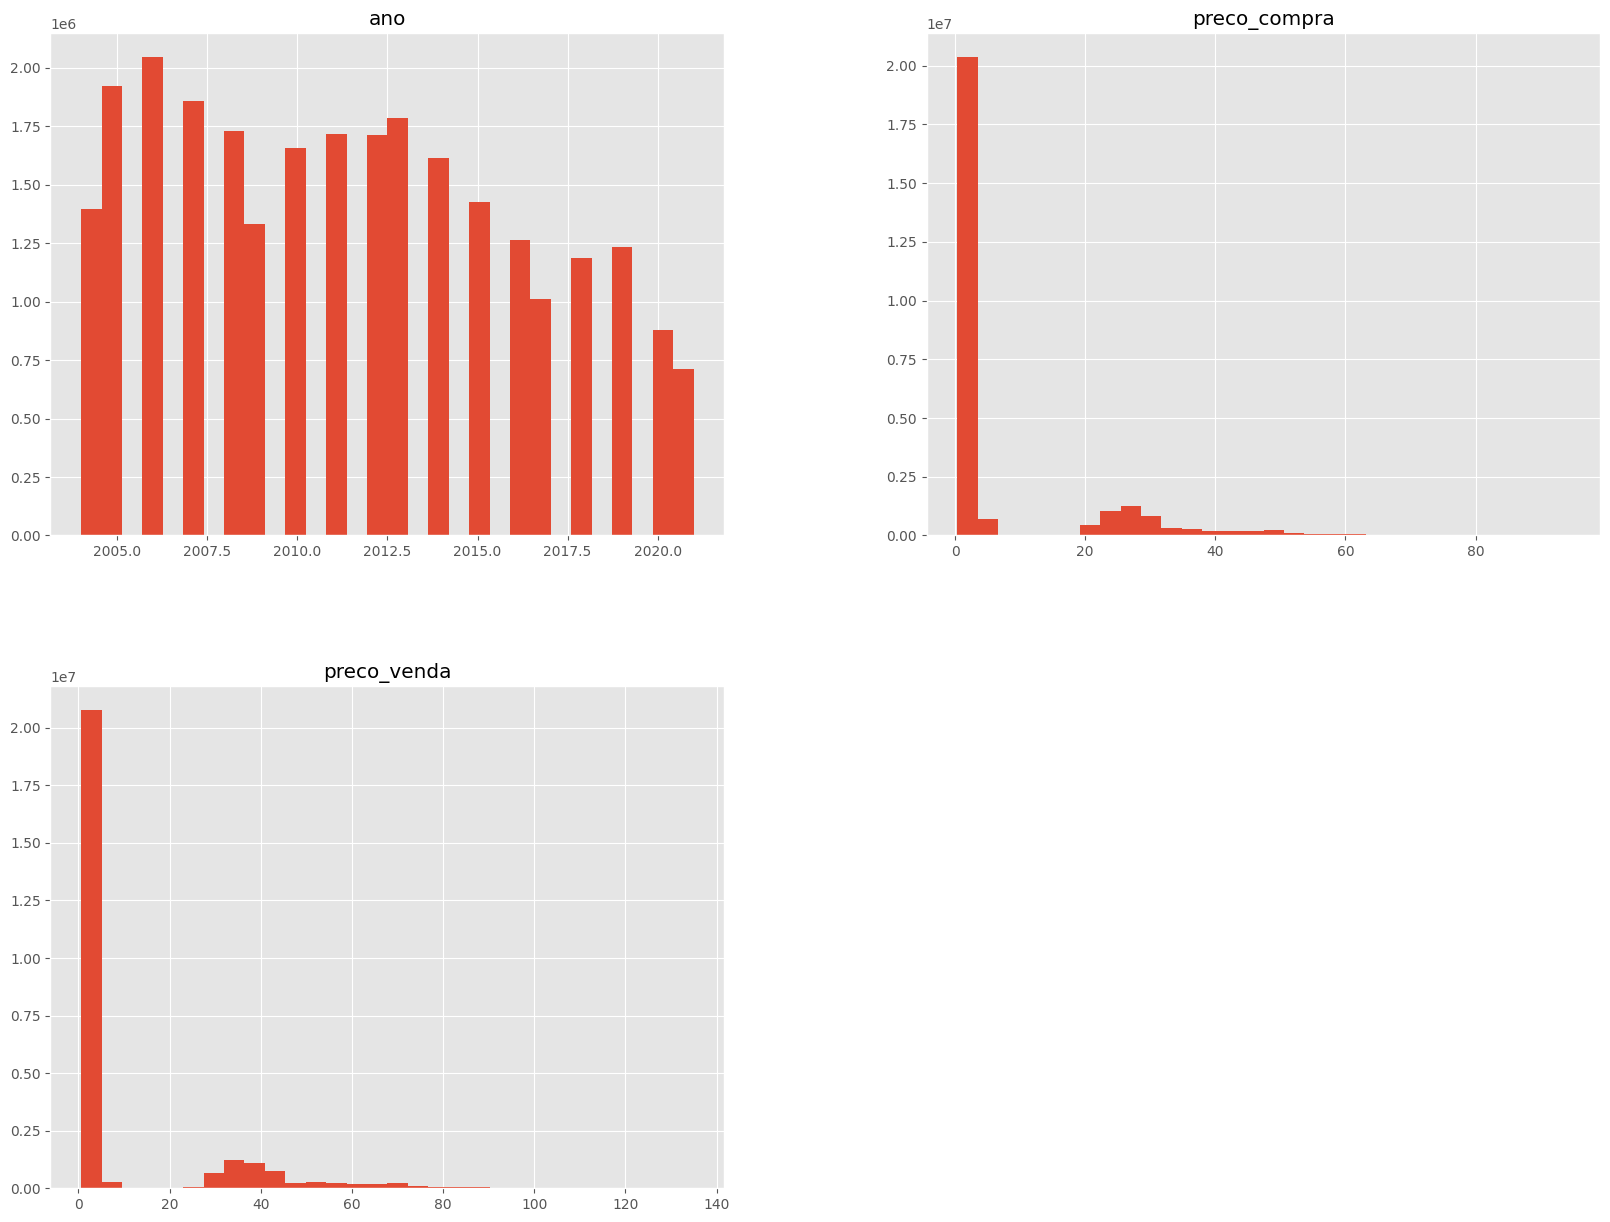

In [16]:
# Plotagem de histogramas 
# Histogramas expressam a distribuição de frequência para variáveis numéricas

df.hist(bins=30,figsize=(20,15))

In [17]:
# Verificando quais são os tipos de produtos, em ordem alfabética, avaliados neste dataset
produtos = sorted(df.produto.unique())
produtos

['diesel',
 'diesel s10',
 'etanol',
 'gasolina',
 'gasolina aditivada',
 'glp',
 'gnv']

In [18]:
# Verificar a quantidade de anos que os dados de cada tipo de produto abrangem 
print('dielsel: ',df.ano[df.produto == 'diesel'].nunique())
print('dielsel s10: ',df.ano[df.produto == 'diesel s10'].nunique())
print('dielsel s50: ',df.ano[df.produto == 'diesel s50'].nunique())
print('etanol: ',df.ano[df.produto == 'etanol'].nunique())
print('gasolina: ',df.ano[df.produto == 'gasolina'].nunique())
print('glp: ',df.ano[df.produto == 'glp'].nunique())
print('gnv: ',df.ano[df.produto == 'gnv'].nunique())

dielsel:  18
dielsel s10:  10
dielsel s50:  0
etanol:  18
gasolina:  18
glp:  18
gnv:  18


In [19]:
df = df[df.produto != 'diesel s50']

In [20]:
df.head()

,ano,sigla_uf,cep_revenda,endereco_revenda,cnpj_revenda,nome_estabelecimento,bandeira_revenda,data_coleta,produto,unidade_medida,preco_compra,preco_venda,municipio
0,2021,RJ,26165-225,"AVENIDA JOAQUIM DA COSTA LIMA,5271 LT 6,7,8,9 ...",02.181.025/0001-64,POSTO NOVO AMIGO LTDA,ALESAT,2021-05-24,gasolina aditivada,R$/litro,4.4093,6.299,Belford Roxo
1,2021,SP,14806-150,"AVENIDA MARIA ANTONIA CAMARGO DE OLIVEIRA,3,571",29.017.490/0001-10,JOAQUIM FERREIRA VIEIRA NETO EIRELI,BRANCA,2021-05-24,gasolina aditivada,R$/litro,3.9193,5.599,Araraquara
2,2021,PE,56509-540,"RUA ARMANDO DE SIQUEIRA BRITO,810",32.395.288/0001-37,AUTO POSTO SAO MIGUEL COMERCIO DE COMBUSTIVEIS...,TEMAPE,2021-05-24,gasolina aditivada,R$/litro,3.8493,5.499,Arcoverde
3,2021,SP,13870-260,"RUA TIRADENTES,224",49.386.147/0001-50,COMERCIAL DE PETROLEO REIS LTDA,BRANCA,2021-05-24,gasolina aditivada,R$/litro,3.8843,5.549,São João da Boa Vista
4,2021,BA,43700-000,"RODOVIA BR 324,S/N KM. 605 6 P...",04.136.094/0002-62,G.R.REVENDEDORA DE COMBUSTIVEIS E LUBRIFICANTE...,RAIZEN,2021-05-25,gasolina aditivada,R$/litro,4.3190,6.170,Simões Filho


In [21]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby('produto').preco_compra.mean().sort_values().reset_index()
df_preco_venda  = df.groupby('produto').preco_venda.mean().sort_values().reset_index()

# Identificando a unidade de medida de cada um dos tipos de produto
df_unidade_medida = df.groupby('produto').unidade_medida.unique().reset_index()

# Agrupando os DataFrames
df_produto = df_preco_compra.merge(df_preco_venda,on='produto').merge(df_unidade_medida,on='produto')

# Criando nova coluna com a diferença entre os preços
df_produto['lucro'] = df_produto.preco_venda - df_produto.preco_compra

# Criando nova coluna com a margem de lucro
df_produto['margem_lucro'] = 100*df_produto.lucro/df_produto.preco_venda

# Visualizar o DataFrame
df_produto

,produto,preco_compra,preco_venda,unidade_medida,lucro,margem_lucro
0,gnv,1.282971,1.835100,[R$/m3],0.552129,30.087137
1,etanol,1.601688,2.094484,[R$/litro],0.492797,23.528307
2,diesel,1.774589,2.242286,[R$/litro],0.467696,20.858020
3,gasolina,2.347962,2.997807,[R$/litro],0.649845,21.677352
4,diesel s10,2.520840,3.312152,[R$/litro],0.791312,23.891171
5,gasolina aditivada,3.940120,5.628743,[R$/litro],1.688623,30.000000
6,glp,31.774890,44.219983,[R$/13kg],12.445093,28.143596


In [22]:
# Deletando o dataframe df_descritive_statistics pois não utilizaremos mais futuramente
del df_produto, df_unidade_medida
gc.collect()

40

In [23]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby(['produto','ano']).preco_compra.mean().reset_index().sort_values(by=['produto','ano'])
df_preco_venda  = df.groupby(['produto','ano']).preco_venda.mean().reset_index().sort_values(by=['produto','ano']).drop(['ano','produto'],axis=1)

# Agrupando os DataFrames
df_produto_ano = pd.concat([df_preco_compra,df_preco_venda],axis=1)

# Criando nova coluna com a diferença entre os preços
df_produto_ano['lucro'] = df_produto_ano.preco_venda - df_produto_ano.preco_compra

# Criando nova coluna com a margem de lucro
df_produto_ano['margem_lucro'] = 100*df_produto_ano.lucro/df_produto_ano.preco_venda

# Visualizar o DataFrame
df_produto_ano

,produto,ano,preco_compra,preco_venda,lucro,margem_lucro
0,diesel,2004,1.255268,1.516346,0.261078,17.217591
1,diesel,2005,1.438730,1.741082,0.302352,17.365731
2,diesel,2006,1.568120,1.882685,0.314565,16.708327
3,diesel,2007,1.566384,1.875402,0.309018,16.477418
4,diesel,2008,1.668762,2.035832,0.367070,18.030456
...,...,...,...,...,...,...
97,gnv,2017,1.644563,2.351250,0.706688,30.055822
98,gnv,2018,1.908975,2.730804,0.821829,30.094775
99,gnv,2019,2.268804,3.216014,0.947210,29.452910
100,gnv,2020,2.224017,3.169041,0.945023,29.820491


In [24]:
# DataFrames para cada tipo de produto
diesel = df_produto_ano[df_produto_ano.produto == 'diesel']
diesel_s10 = df_produto_ano[df_produto_ano.produto == 'diesel s10']
etanol = df_produto_ano[df_produto_ano.produto == 'etanol']
gasolina = df_produto_ano[df_produto_ano.produto == 'gasolina']
glp = df_produto_ano[df_produto_ano.produto == 'glp']
gnv = df_produto_ano[df_produto_ano.produto == 'gnv']

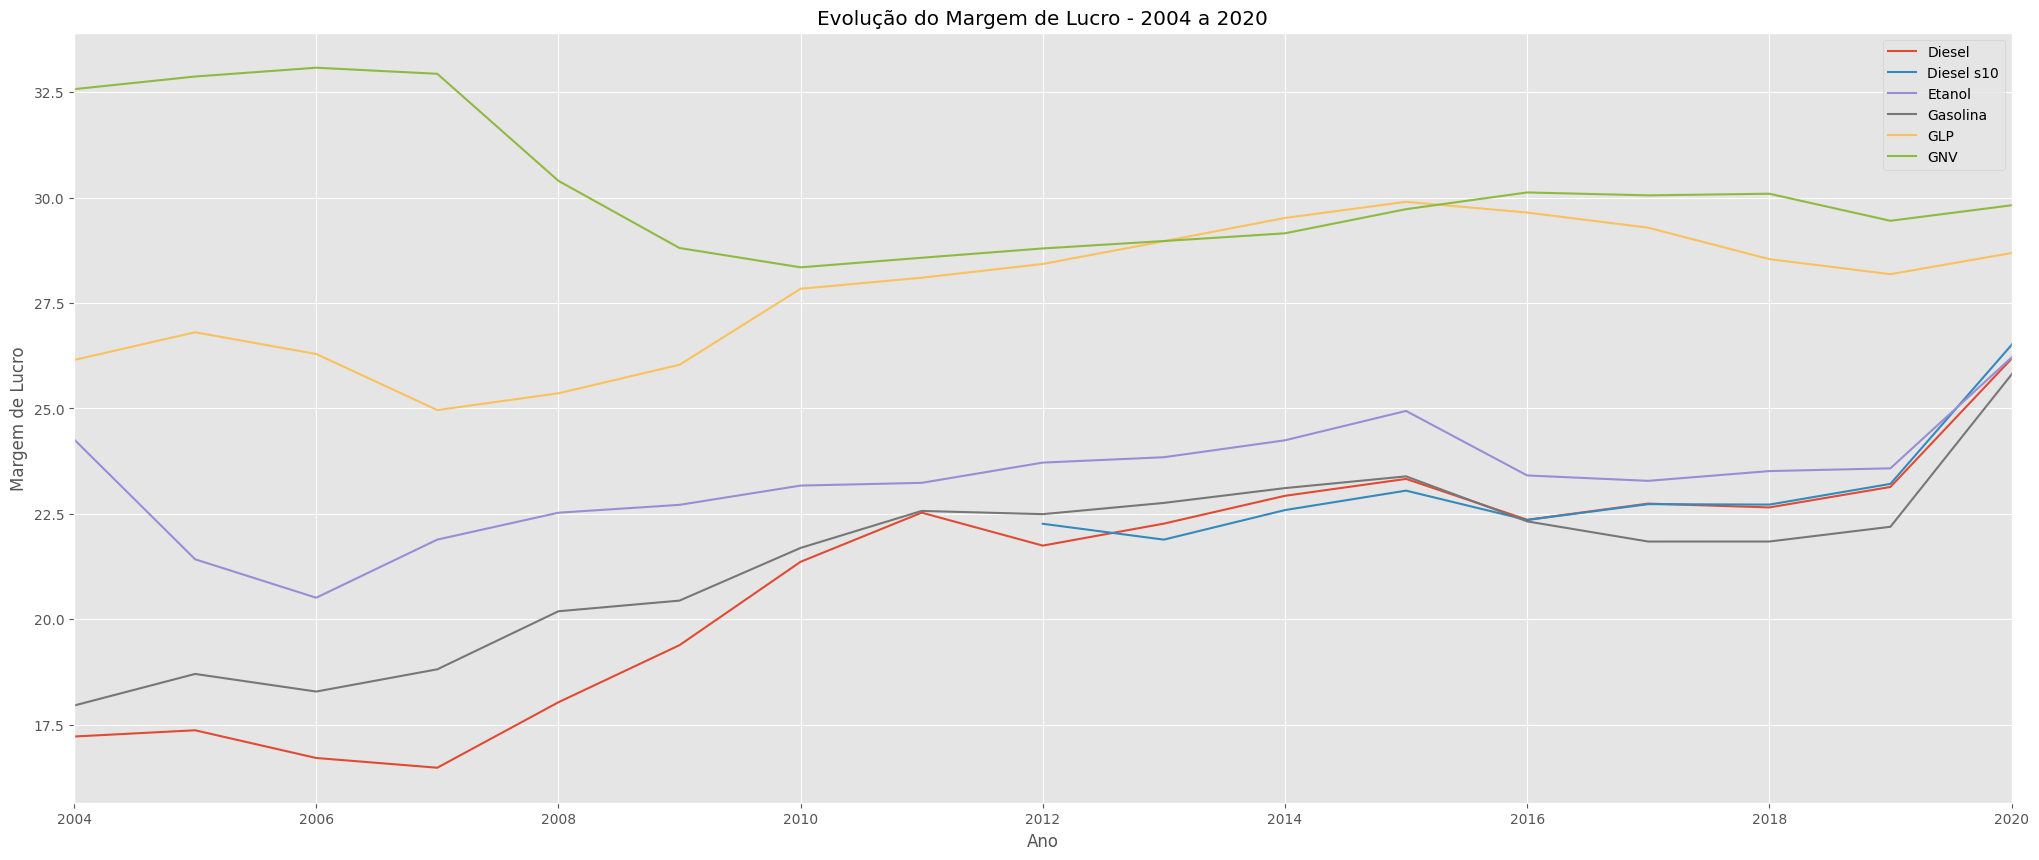

In [25]:
# Plotagem dos gráficos
plt.figure(figsize=(25,10))
sns.lineplot(data=diesel,x='ano',y='margem_lucro',label='Diesel');
sns.lineplot(data=diesel_s10,x='ano',y='margem_lucro',label='Diesel s10');
sns.lineplot(data=etanol,x='ano',y='margem_lucro',label='Etanol');
sns.lineplot(data=gasolina,x='ano',y='margem_lucro',label='Gasolina');
sns.lineplot(data=glp,x='ano',y='margem_lucro',label='GLP');
sns.lineplot(data=gnv,x='ano',y='margem_lucro',label='GNV');
plt.xlabel('Ano')
plt.ylabel('Margem de Lucro')
plt.title('Evolução do Margem de Lucro - 2004 a 2020')
plt.xlim([2004,2020])
plt.legend();

In [26]:
# Deletando dataframes que não utilizaremos mais futuramente
del diesel, diesel_s10, etanol, gasolina, glp, gnv
gc.collect();

Nota-se que as informações a respeito do Diesel s10 só estão disponíveis a partir de 2012. Isso provavelmente se deve ao fato de que o diesel com baixo teor de enxofre, o S10 se tornou obrigatório para o transporte rodoviário a partir do ano de 2012, justamente por conter menos enxofre e ser menos poluente.

No ano de 2004, o GNV e o etanol tiveram o maior percentual de lucro e a partir deste ano, o etanol deu lugar ao GLP como segundo maior percentual de lucro até 2020.

Vale mencionar que de 2004 a 2016, o percentual de lucro com a venda de gasolina era bem maior do que o gerado pelo diesel. No ano de 2017, houve a inversão disto e esse padrão se manteve até o ano de 2020.

Outro ponto bastante interessante é o fato de que o diesel s10, menos poluente que o diesel comum e o diesel s50, levou 3 anos (desde a obrigatoriedade para o uso no transporte rodoviário) para atingir o percentual de lucro dos demais tipos de diesel e, no ano seguinte, se tornou mais lucrativo que os outros, padrão que se manteve até 2020.

Percebe-se que de 2004 a 2020, houve: uma considerável redução da margem de lucro para o GNV e etanol, a margem referente à gasolina sofreu uma pequena redução, enquanto a margem relacionada ao diesel sofreu um leve aumento. O diesel s10, por sua vez, teve um aumento considerável na sua margem de lucro

Text(0.5, 1.0, 'Boxplot: Preço de Compra x Estado')

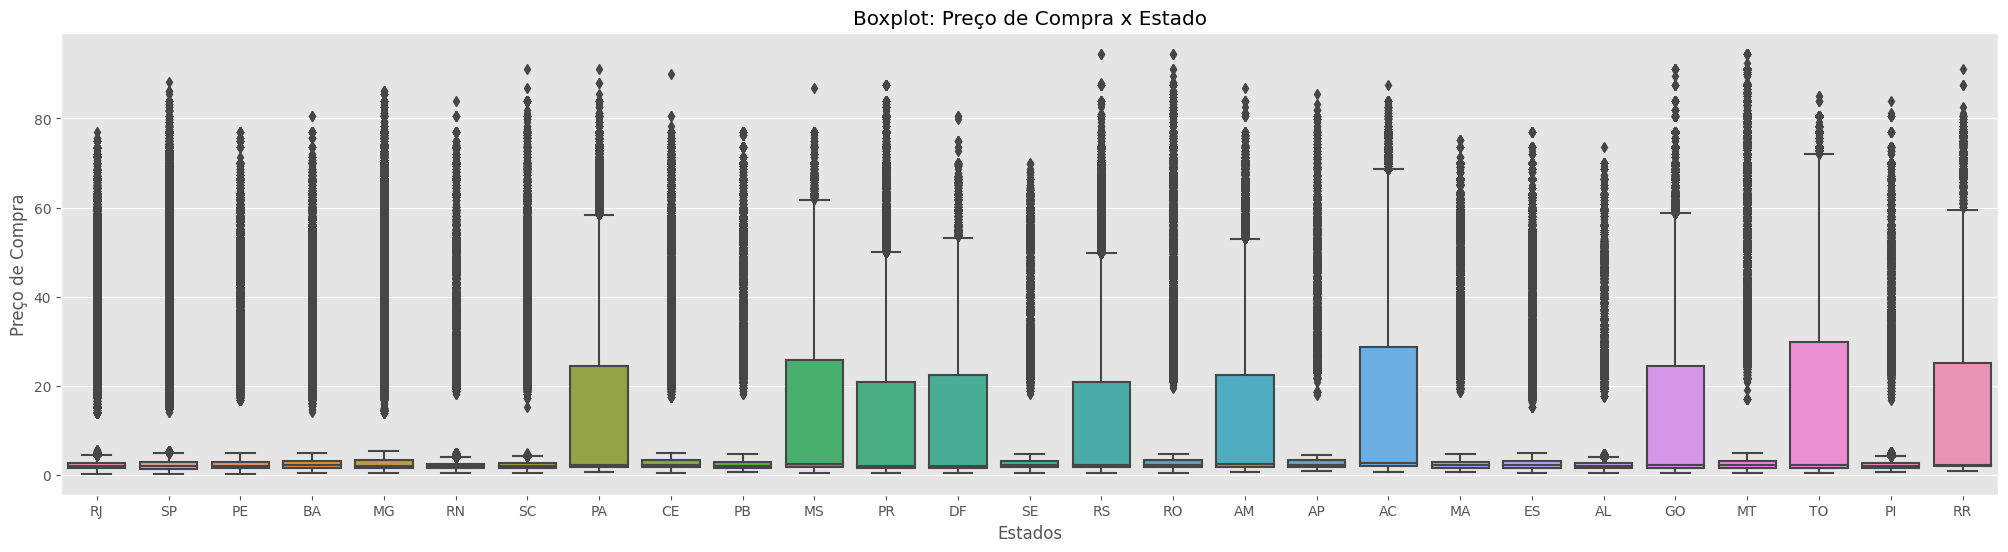

In [27]:
# Afim de visualizar a distribuição dos dados para cada variável e identificar possíveis outliers
plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_compra',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra')
plt.title('Boxplot: Preço de Compra x Estado')

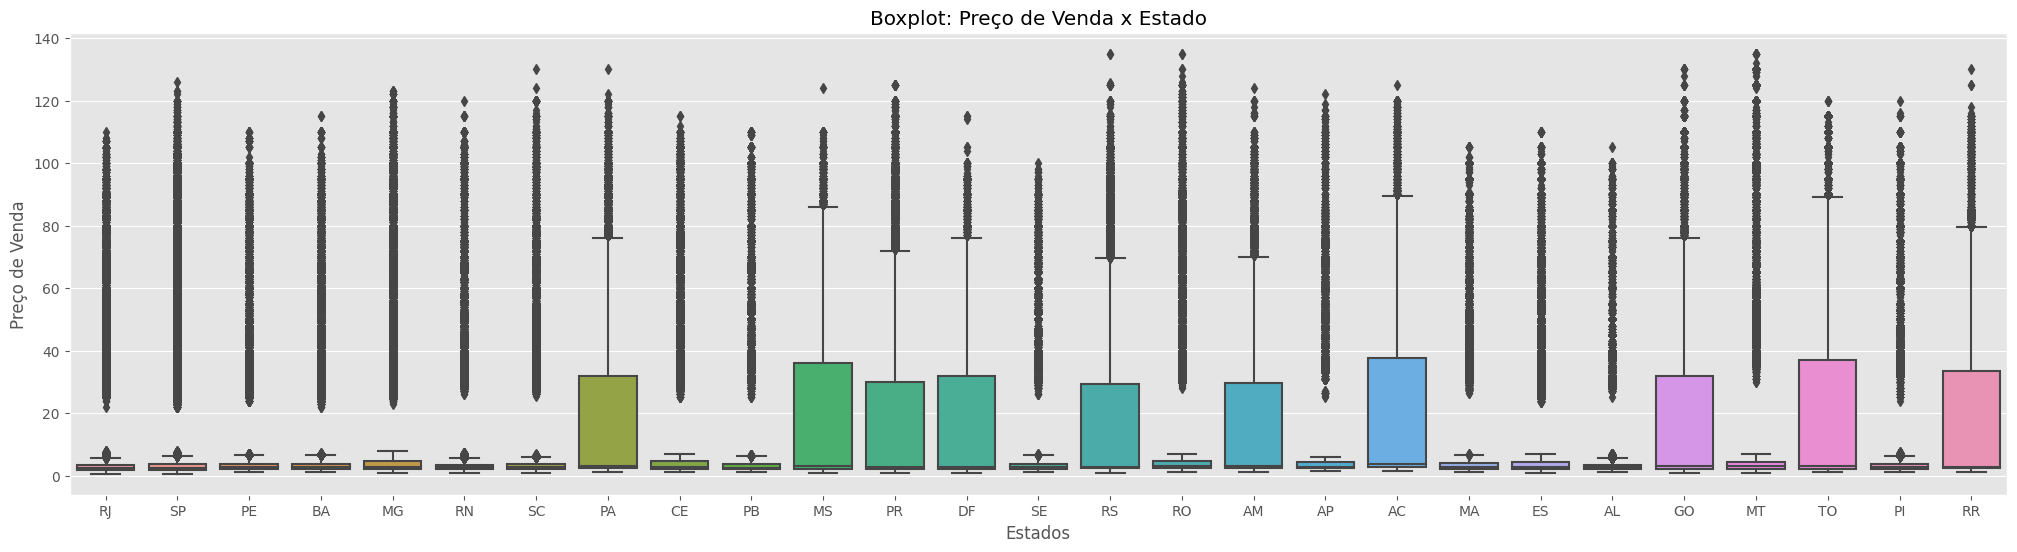

In [28]:
plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_venda',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Venda')
plt.title('Boxplot: Preço de Venda x Estado');

Através do boxplot, identificamos diversos outliers. Além disso, nota-se que as distribuições de preço de compra e preço de venda para os estados: Acre, Roraima, Amazonas e Goiás, são bem menos concentradas do que as demais distribuições referentes aos outros estados. Isso, indica uma grande volatilidade nos dados para estes estados. Outro ponto relevante é que destes 4 estados, 3 deles pertencem à região norte.

<h1>Margem de Lucro por Estado</h1>

In [29]:
df_precos_estados = df.groupby(['sigla_uf','produto']).agg({'preco_compra':'mean','preco_venda':'mean'}).reset_index()

# Criando nova coluna com a diferença entre os preços
df_precos_estados['lucro'] = df_precos_estados.preco_venda - df_precos_estados.preco_compra

# Criando nova coluna com a margem de lucro
df_precos_estados['margem_lucro'] = 100*df_precos_estados.lucro/df_precos_estados.preco_venda

df_precos_estados_diesel = df_precos_estados[df_precos_estados.produto == 'diesel'][['sigla_uf','margem_lucro']].sort_values(by='margem_lucro',ascending=False)

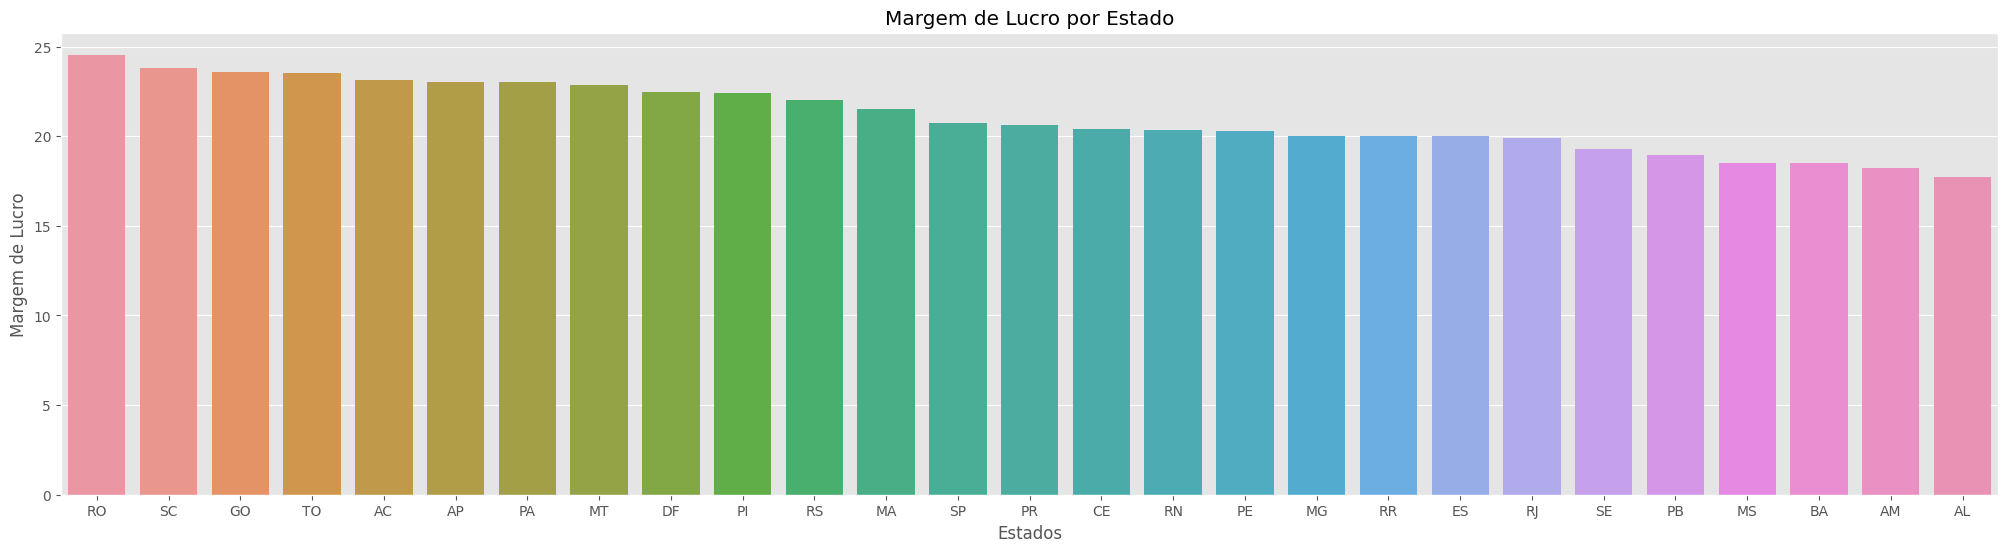

In [30]:
plt.figure(figsize=(25,6))
plt.title('Margem de Lucro por Estado');
sns.barplot(data=df_precos_estados_diesel,x='sigla_uf',y='margem_lucro')
plt.xlabel('Estados')
plt.ylabel('Margem de Lucro');

Nota-se que as maiores margens de lucro foram para os estados: Acre, Roraima, Rio Grande do Sul, Tocantins, Pará, Rondônia, Amazonas, São Paulo, Santa Catarina e Rio de Janeiro. Percebe-se que com exceção do estado de Goiás, os demais estados que apresentaram grande volatilidade dos preços de compra e de venda estiveram entre os estados com maior margem de lucro no país, a exemplo de: Acre, Roraima e Amazonas.

In [31]:
# Deletando dataframes que não utilizaremos mais futuramente
del df_precos_estados, df_precos_estados_diesel
gc.collect();

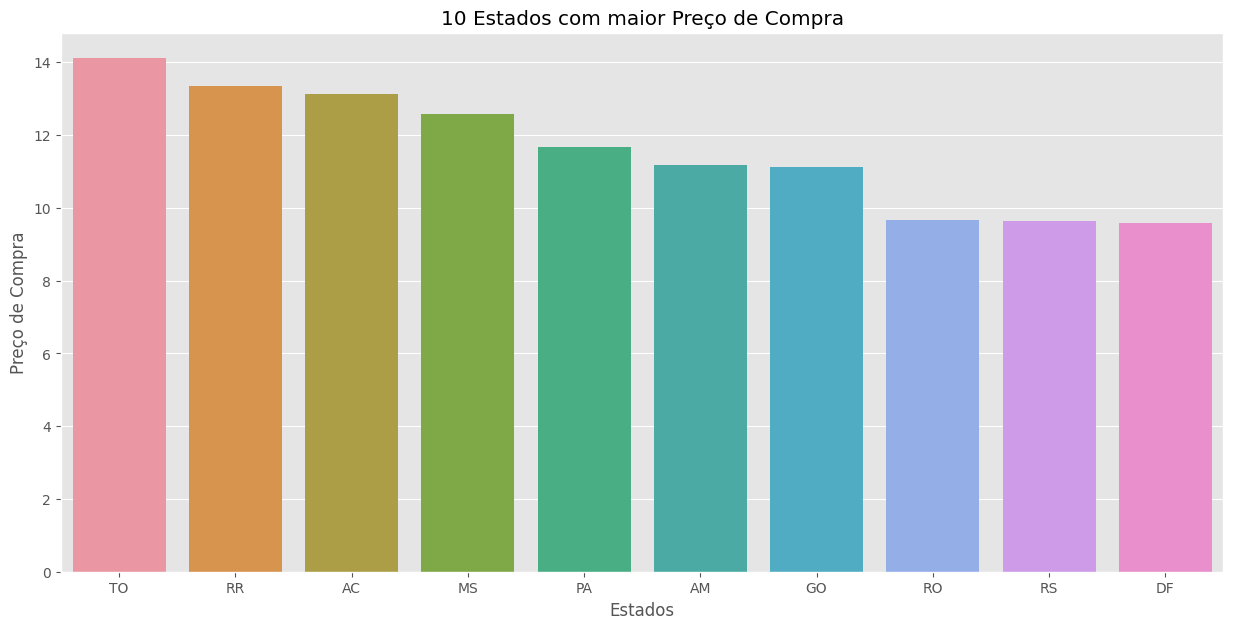

In [32]:
plt.figure(figsize=(15,7))
df_preco_compra_top10 = df.groupby('sigla_uf').preco_compra.mean().reset_index().sort_values(by='preco_compra',ascending=False)[:10]
sns.barplot(data=df_preco_compra_top10,x='sigla_uf',y='preco_compra').set_title('10 Estados com maior Preço de Compra')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra');

Nota-se que os estados: Acre, Roraima e Amazonas pertencentes aos estados com maiores margens de lucro também estão entre os estados com maior preço de compra. O preço de compra dos combustíveis pelas revendedoras é influenciado por fatores como: custo de produção da Petrobras nas refinarias, impostos federais e estaduais (ICMS, PIS/Pasep e Cofins, e Cide) e custo do etanol anidro obrigatório. Dessa forma, pode-se observar que os impostos estaduais impactam consideravelmente no preço de compra.

In [33]:
del df_preco_compra_top10
gc.collect();

<h1>10 Estados com maior Preço de Venda</h1>

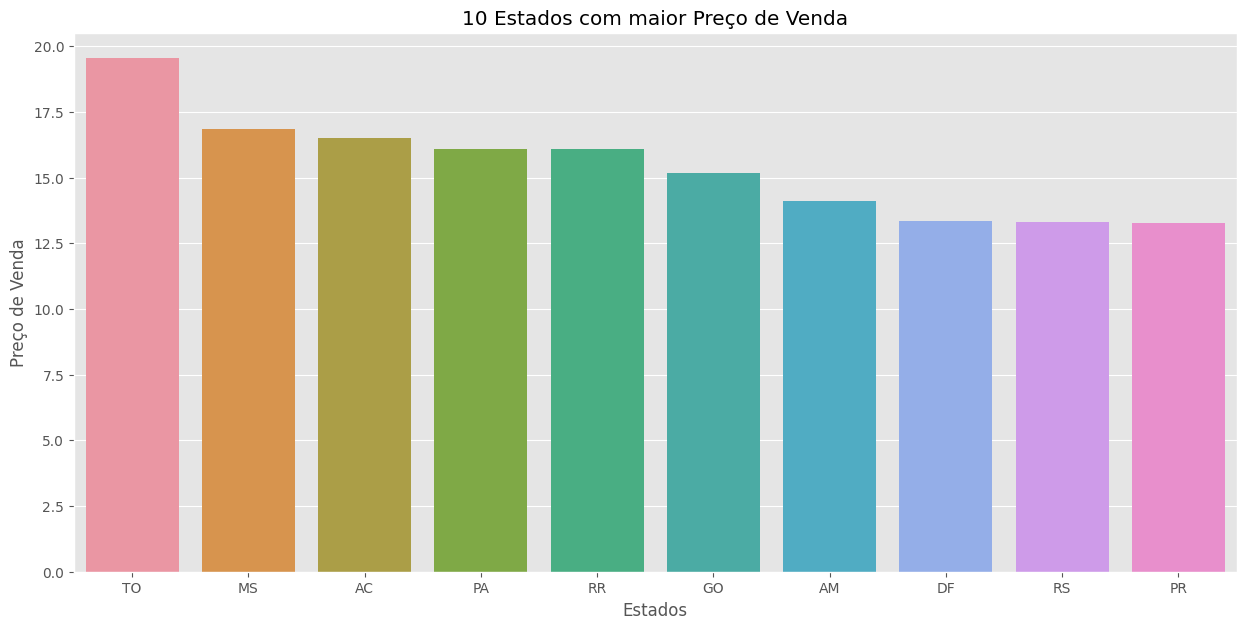

In [34]:
plt.figure(figsize=(15,7))
df_preco_venda_top10 = df.groupby('sigla_uf').preco_venda.mean().reset_index().sort_values(by='preco_venda',ascending=False)[:10]
sns.barplot(data=df_preco_venda_top10,x='sigla_uf',y='preco_venda').set_title('10 Estados com maior Preço de Venda')
plt.xlabel('Estados')
plt.ylabel('Preço de Venda');

Nota-se que os estados: Acre, Roraima e Amazonas pertencentes aos estados com maiores margens de lucro e estão entre os estados com maior preço de compra também estão entre os estados com maior preço de venda. Indicando, dessa forma, uma possível relação entre estas duas variáveis, o que faz todo sentido uma vez que para manter a rentabilidade das revendedoras se torna necessário aumentar o preço de venda quando ocorre aumento no preço de compra.

In [35]:
del df_preco_venda_top10
gc.collect();

<h1>Análise Bivariada</h1>

<p>A importância desse tipo de gráfico é observar o comportamento das variáveis através de histogramas na diagonal e scatterplots fora da diagonal. Esses scatterplots representam a relação entre os pares de features.</p>

In [36]:
sns.pairplot(df)
plt.show()

In [ ]:
# Aplicando coeficiente de correlação de Pearson
df_corr = df.corr()

In [ ]:
# Visualizar a correlação entre cada variável utilizando a correlação de Pearson 
_ = plt.figure(figsize = (20,10))
res = sns.heatmap(df_corr, vmax = 1, linewidths = 0.9, cmap = 'viridis',annot_kws={"size": 15},annot=True)
_ = plt.title('Pearson Correlation', fontsize = 20, pad = 15)
_ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
_ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

O coeficiente de correlação de Pearson nos auxiliar a identificar a intensidade e a direção da relação linear entre duas variáveis. Neste caso, nota-se que a correlação entre as variáveis: preço de compra e preço de venda realmente é significantemente alta, indicando que um aumento no preço de compra é acompanhado por um aumento no preço de venda.

In [ ]:
# Economizando RAM
del df_corr, res
gc.collect()